# World Data League 2022

## Notebook Submission Template

This notebook is one of the mandatory deliverables when you submit your solution. Its structure follows the WDL evaluation criteria and it has dedicated cells where you should add information. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work. Make sure to list all the datasets used besides the ones provided.

Instructions:
1. 🧱 Create a separate copy of this template and **do not change** the predefined structure
2. 👥 Fill in the Authors section with the name of each team member
3. 💻 Develop your code - make sure to add comments and save all the output you want the jury to see. Your code **must be** runnable!
4. 📄 Fill in all the text sections
5. 🗑️ Remove this section (‘Notebook Submission Template’) and any instructions inside other sections
6. 📥 Export as HTML and make sure all the visualisations are visible.
7. ⬆️ Upload the .ipynb file to the submission platform.


## 🎯 Challenge
### Predict Waste Production for its Reduction

## 👥 Authors
* Nicholas Sistovaris
* Sai Pravallika Mynesi
* Wiem Borchani
* Shaah Neha

### Context 

According to the World Bank, in 2016 cities generated 2.01 billion tons of solid waste. Per
person, this is around 0.74 kg/day! With the rapid growth of cities, this number is only
expected to increase. As cities are growing, it is urgent that optimization processes for
waste processing and more targeted public education on waste management and
separation. Finally, it is also important to note that waste collection also has an impact on air pollution.

### Goal & Outcome

The goal of this challenge is to help identify trends in waste production and help to create
insights into how to reduce waste and optimize its collection. The expected outcome to this challenge is to identify waste trends and to produce an
explainable model for predicting future waste production.
Finally, don’t forget to propose the application (product) for the model and study its
impact.

### Data

Austin Resource Recovery daily report providing waste collection information based on the following categories:
- Report Date: The date collections information was recorded.
- Load Type: The specific type of load that is being collected on that day.
- Load Time: Date & Time of Loading
- Load Weight: The weight (in pounds) collected for each service on the day it was delivered to a diversion facility
- Drop off Site: The location where each type of waste is delivered for disposal, recycling or reuse: TDS Landfill indicates the Texas Disposal System landfill located at 12200 Carl Rd, Creedmoor, TX 78610; Balcones Recycling is a recycling facility located at 9301 Johnny Morris Road Austin, TX 78724; MRF is a Materials Recycling Facility (such as Texas Disposal Systems or Balcones Recycling); Hornsby Bend is located at 2210 FM 973, Austin, TX 78725 and accepts food scraps, yard trimmings, food-soiled paper and other materials collected by ARR, and combined with other waste to produce nutrient-rich dillo dirt, used for landscaping.
- Route Type: The general category of collection service provided by Austin Resource Recovery
- Route Number: Austin Resource Recovery route that the truck that collected this load was following. Each route has abbreviated letters indicating the service type (e.g. Bulk = "BU") and a number indicating the specific route.

This information is used to help ARR reach its goals to transform waste into resources while keeping our community clean. For more information, visit www.austintexas.gov/department/austin-resource-recovery

## 💻 Development
Start coding here! 🐱‍🏍

Create the necessary subsections (e.g. EDA, different experiments, etc..) and markdown cells to include descriptions of your work where you see fit. Comment your code. 

All new subsections must start with three hash characters.

Pro-tip 1: Don't forget to make the jury's life easier. Remove any unnecessary prints before submitting the work. Hide any long output cells (from training a model for example). For each subsection, have a quick introduction (justifying what you are about to do) and conclusion (results you got from what you did). 

Pro-tip 2: Have many similiar graphs which all tell the same story? Add them to the appendix and show only a couple of examples, with the mention that all the others are in the appendix.

### Libraries & Settings

In [2]:
!pip install holidays -q
!pip install meteostat -q

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
# basic
import pandas as pd
import math
import requests
import numpy as np
import json


# datetime
from datetime import datetime
from datetime import date
import holidays
import datetime as dt

# meteostat
from meteostat import Point, Daily, Stations, Hourly


# visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# geo
import fiona
import geopandas as gpd
#import osmnx as ox
#import osmium
from shapely.geometry import shape 

# setting options for displaying
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_columns', None) 

### Importing Data & Basic Exploration

In [4]:
# importing data
data_raw = pd.read_csv("data/waste_data.csv")
data_raw.head(2)

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
0,12/08/2020,BULK,12/08/2020 03:02:00 PM,5220.000000,TDS LANDFILL,BULK,BU13,899097
1,12/08/2020,RECYCLING - SINGLE STREAM,12/08/2020 10:00:00 AM,11140.000000,TDS - MRF,RECYCLING - SINGLE STREAM,RTAU53,899078


In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740873 entries, 0 to 740872
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Report Date   740873 non-null  object 
 1   Load Type     740873 non-null  object 
 2   Load Time     740873 non-null  object 
 3   Load Weight   668538 non-null  float64
 4   Dropoff Site  740873 non-null  object 
 5   Route Type    740873 non-null  object 
 6   Route Number  740873 non-null  object 
 7   Load ID       740873 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 45.2+ MB


So far we believe that the most interesting features for our time series will be :
- Load Type
- Load Time
- Load Weight
- Dropoff Site
- Route Number

We believe that Report Date is not really useful as there are major discrepancies between the report date and the load time. 

In [6]:
data_raw.describe()

,Load Weight,Load ID
count,668538.000000,740873.000000
mean,11763.477576,521353.123651
std,7554.855662,249972.621259
min,-4480.000000,101223.000000
25%,5740.000000,289609.000000
50%,11020.000000,554862.000000
75%,16520.000000,741648.000000
max,1562821.000000,929006.000000


In [7]:
# checking for missing value in Load Weight
len(data_raw[np.isnan(data_raw["Load Weight"])])/data_raw.shape[0]

0.09763481730337048

In [8]:
# removing NaN valued from Load Weight
data = data_raw[np.isnan(data_raw["Load Weight"]) == False]

In [9]:
# turning both dates into datetime
data["Report Date"] = pd.to_datetime(data["Report Date"])
data["Load Time"] = pd.to_datetime(data["Load Time"])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
# Here we can see two typos which we can correct for
# The year was inputted wrong while the date and month were inputed right 
data[pd.DatetimeIndex(data["Load Time"]).year > 2021] 

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
354250,2020-11-24,DEAD ANIMAL,2030-11-24 13:49:00,320.000000,TDS LANDFILL,DEAD ANIMAL,DA02,897529
730958,2020-07-29,DEAD ANIMAL,2030-07-29 14:08:00,260.000000,TDS LANDFILL,DEAD ANIMAL,DA01,883665


In [11]:
data[pd.DatetimeIndex(data["Load Time"]).year < 2004] 

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
107125,2012-10-16,BULK,2001-10-16 15:28:00,8260.000000,TDS LANDFILL,BULK,BU16,545996
175739,2012-03-16,BULK,2001-03-16 13:33:00,4740.000000,TDS LANDFILL,BULK,BU05,522334
322083,2012-10-16,BULK,2001-10-16 11:51:00,14080.000000,TDS LANDFILL,BULK,BU16,545997
343252,2006-01-26,RECYCLING - PAPER,2000-01-26 12:39:00,2940.000000,MRF,RECYCLING,RH12,163262
550853,2012-03-16,BULK,2001-03-16 09:38:00,4240.000000,TDS LANDFILL,BULK,BU05,522335


In [12]:
data.sort_values(by = "Load Time", ascending = False)

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
354250,2020-11-24,DEAD ANIMAL,2030-11-24 13:49:00,320.000000,TDS LANDFILL,DEAD ANIMAL,DA02,897529
730958,2020-07-29,DEAD ANIMAL,2030-07-29 14:08:00,260.000000,TDS LANDFILL,DEAD ANIMAL,DA01,883665
717844,2020-12-21,RECYCLING - SINGLE STREAM,2021-12-21 12:41:00,6940.000000,TDS LANDFILL,RECYCLING - SINGLE STREAM,RMAU21,906125
739696,2020-11-24,ORGANICS,2021-12-07 00:00:00,1340.000000,ORGANICS BY GOSH,YARD TRIMMINGS-ORGANICS,OBT99,927983
740735,2021-06-28,MIXED LITTER,2021-07-11 07:07:45,3140.000000,TDS LANDFILL,KAB,KAB02,927260
...,...,...,...,...,...,...,...,...
107125,2012-10-16,BULK,2001-10-16 15:28:00,8260.000000,TDS LANDFILL,BULK,BU16,545996
322083,2012-10-16,BULK,2001-10-16 11:51:00,14080.000000,TDS LANDFILL,BULK,BU16,545997
175739,2012-03-16,BULK,2001-03-16 13:33:00,4740.000000,TDS LANDFILL,BULK,BU05,522334
550853,2012-03-16,BULK,2001-03-16 09:38:00,4240.000000,TDS LANDFILL,BULK,BU05,522335


In [13]:
data[data["Route Number"] == "PF33"]

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
690,2020-12-11,GARBAGE COLLECTIONS,2020-12-11 14:00:00,11200.000000,TDS LANDFILL,GARBAGE COLLECTION,PF33,899738
4141,2008-10-03,GARBAGE COLLECTIONS,2008-10-03 14:30:00,16720.000000,TDS LANDFILL,GARBAGE COLLECTION,PF33,298658
4324,2011-10-14,GARBAGE COLLECTIONS,2011-10-14 13:00:00,20280.000000,TDS LANDFILL,GARBAGE COLLECTION,PF33,505506
5820,2011-08-05,GARBAGE COLLECTIONS,2011-08-05 13:19:00,16140.000000,TDS LANDFILL,GARBAGE COLLECTION,PF33,419577
8596,2005-09-23,GARBAGE COLLECTIONS,2005-09-23 13:03:00,21040.000000,TDS LANDFILL,GARBAGE COLLECTION,PF33,146559
...,...,...,...,...,...,...,...,...
735999,2021-06-04,GARBAGE COLLECTIONS,2021-06-04 14:00:00,15300.000000,TDS LANDFILL,GARBAGE COLLECTION,PF33,924171
737155,2021-06-11,GARBAGE COLLECTIONS,2021-06-11 13:53:00,18800.000000,TDS LANDFILL,GARBAGE COLLECTION,PF33,925397
737853,2021-06-18,GARBAGE COLLECTIONS,2021-06-18 12:20:00,13160.000000,TDS LANDFILL,GARBAGE COLLECTION,PF33,926073
739478,2021-06-25,GARBAGE COLLECTIONS,2021-06-24 13:28:00,15100.000000,TDS LANDFILL,GARBAGE COLLECTION,PF33,927180


In [14]:
data["Load Type"].value_counts()

GARBAGE COLLECTIONS            258395
RECYCLING - SINGLE STREAM      147612
YARD TRIMMING                   69554
BULK                            40117
BRUSH                           39141
RECYCLING - PAPER               32155
RECYCLING - COMINGLE            31116
ORGANICS                        17705
SWEEPING                        16522
DEAD ANIMAL                      6856
TIRES                            3205
MIXED LITTER                     2110
LITTER                           1539
MULCH                            1344
RECYCLED METAL                   1049
BAGGED LITTER                      43
RECYCLING - PLASTIC BAGS           40
YARD TRIMMING - X-MAS TREES        16
MATTRESS                            9
CONTAMINATED RECYCLING              8
CONTAMINATED YARD TRIMMINGS         1
CONTAMINATED ORGANICS               1
Name: Load Type, dtype: int64

In [15]:
# We decided to remove the categories of waste with low value count as seen on table above.
# We believe they would not provide relevant information insofar as we have the other
counts = data['Load Type'].value_counts()

data = data.loc[data['Load Type'].isin(counts.index[counts > 1000])]

In [16]:
data["Load Type"].value_counts()

GARBAGE COLLECTIONS          258395
RECYCLING - SINGLE STREAM    147612
YARD TRIMMING                 69554
BULK                          40117
BRUSH                         39141
RECYCLING - PAPER             32155
RECYCLING - COMINGLE          31116
ORGANICS                      17705
SWEEPING                      16522
DEAD ANIMAL                    6856
TIRES                          3205
MIXED LITTER                   2110
LITTER                         1539
MULCH                          1344
RECYCLED METAL                 1049
Name: Load Type, dtype: int64

In [17]:
data["Dropoff Site"].value_counts()

TDS LANDFILL             325728
HORNSBY BEND              94636
MRF                       89599
BALCONES RECYCLING        60085
TDS - MRF                 55987
ORGANICS BY GOSH          25450
STEINER LANDFILL          11732
BRAKER SITE                2537
ZILKER                      908
PARK BEND                   386
AUSTIN IRON AND METAL       376
COMMERCIAL METALS           306
BFI LANDFILL                289
GREAT NORTHERN               86
AUSTIN WOOD RECYCLING        53
ONION CREEK                  52
WESTFIELD                    51
BALCONES WOODS               42
ON ROUTE HIGH DUMP           24
WINNEBAGO                    20
ST. EDWARDS                  18
INSPIRATION/GUNNISAN         12
PARK CENTER                  10
WILCAB                        9
BURGER CENTER                 7
ELMONT                        5
PEASE PARK                    4
KRAMER                        3
BARTON SKYWAY                 2
LITTER DROPOFF                1
CLARKSON                      1
DEEP EDD

In [18]:
# We decided to remove the dropoff sites with low value count as seen on table above.
# We believe they would not provide relevant information insofar as we have the other
counts = data['Dropoff Site'].value_counts()

data = data.loc[data['Dropoff Site'].isin(counts.index[counts > 10])]

In [19]:
data["Route Number"].value_counts()

DSS04       6857
DA01        4320
BU13        2667
DA02        2629
BU10        2241
            ... 
BLS-01         1
SB63           1
YTSTRH01       1
RWNON38        1
NR34           1
Name: Route Number, Length: 1518, dtype: int64

In [20]:
# We decided to remove the route number with low value count as seen on table above.
# We believe they would not provide relevant information insofar as we have the other
counts = data['Route Number'].value_counts()

data = data.loc[data['Route Number'].isin(counts.index[counts > 100])]

In [21]:
data["Route Number"].value_counts()

DSS04       6857
DA01        4320
BU13        2667
DA02        2629
BU10        2241
            ... 
PAM00        102
OT14         102
PAT68        101
RHAS32       101
PAW69-TF     101
Name: Route Number, Length: 1049, dtype: int64

### Exploration Per Segment

#### Load Type

In [22]:
weightsum_by_type = data[["Load Weight", "Load Type"]].groupby(by = "Load Type").sum()
weightmean_by_type = data[["Load Weight", "Load Type"]].groupby(by = "Load Type").mean()

In [23]:
# Checking Total Weight Collected per Category
# We can see that normal garbage collection is the largest category by far, follwed by recycling, yard trimming, bulk...
weightsum_by_type.sort_values(by= "Load Weight", ascending= False)

,Load Weight
Load Type,
GARBAGE COLLECTIONS,4382757091.539400
RECYCLING - SINGLE STREAM,1445900832.000000
YARD TRIMMING,781828504.000000
BULK,293898053.000000
BRUSH,229958727.000000
SWEEPING,186833955.000000
ORGANICS,148994258.000000
RECYCLING - PAPER,140877900.000000
RECYCLING - COMINGLE,100845699.000000


In [24]:
# Garbage Collections is still first, followed by sweeping, yard trimmings, organics ...
# These are good averages over at least 1000 observations per category
weightmean_by_type.sort_values(by= "Load Weight", ascending= False)

,Load Weight
Load Type,
GARBAGE COLLECTIONS,17121.214965
SWEEPING,11552.928209
YARD TRIMMING,11381.487255
ORGANICS,10860.431373
RECYCLING - SINGLE STREAM,9921.915020
BULK,7548.428227
MULCH,7041.895246
BRUSH,6018.759049
RECYCLING - PAPER,4417.204402


**Front Loader Garbage Trucks**

You will require massive containers to collect all the garbage from industrial and commercial properties. That is when front loader garbage trucks will help you with their size. Their containers, often called dumpsters, are spacious enough to collect industrial waste materials. From, slime and sludge to waste from factories, the design of these trucks make it possible to accommodate all types of garbage inside. They come with steel forks controlled hydraulically. An operator lift picks up the waste materials and dumps them into the container.

Most front loaders available in the US can lift containers weighing approximately 8000 lbs. On the other hand, they can hold trash of up to **40 cubic yards**.

**Side Loader Garbage Trucks**

If industrial waste is not your cup of tea, you can focus on removal of household waste. For this, a side loader garbage truck will be most suitable. You need to load the waste materials from the side. There are two variants available in this truck: one with automatic robotic arms that will collect the garbage and second, manually. The automated side loaders are slightly more expensive. They require only one operator. You can collect rubbish from almost **1500 homes every day**.

The size of the side loader garbage truck plays a crucial role in deciding the quantity of the waste materials it can carry. Most of the standard trucks can hold approximately 30,000 lbs of compacted garbage every day and hold up to 28 cubic yards of garbage. Some of these trucks are available at a budget-friendly price if you buy them second-hand. The manual side loaders will cost lesser compared to the automated side loaders.

**Rear Loader Garbage Trucks**

If you want to serve both commercial and residential clients, then get a rear loader garbage truck. These are the most versatile when it comes to trash collection. Their significant opening at the back allows you to collect massive quantities of waste in one go. Many residential clients keep their garbage inside bin bags. No matter what their size is, you can collect plenty of them inside the truck in one day. Like carrying, these trucks also help in dumping the contents too, thanks to their substantial rear opening.

Most rear loader garbage trucks can accommodate trash from as many as 800 to 850 homes. Some of the bigger variants can haul up to 18 tons of garbage. Their weight capacity ranges from 6 to 35 cubic yards depending on their size. You can purchase one of these used beasts for a very affordable price. But make sure you check the condition of the truck before buying.

**Roll Off Trucks**

These are the most popular garbage trucks when it comes to mass-scale commercial trash removal services. You can see them in demolition and construction sites. Their sturdy construction makes them a perfect fit for handling heavier materials, such as cardboard and steel. These trucks have massive roll off containers that you can drop at specified locations and then pick them up after a period after the clients have loaded them with waste materials.

These help to pick up the loaded container without much effort. A roll off truck can carry approximately 20,000 lbs, which is equal to 10 tons. Its sturdy construction makes sure the truck doesn’t get damaged during the pickup and drop off process.

Most people don’t value the engineering genius of garbage trucks. If you want to flourish in your garbage removal business, make sure you choose one of these trucks for higher efficiency because of the quantity of the trash they can carry.

#### Dropoff Sites

In [25]:
weightsum_by_dropoff = data[["Load Weight", "Dropoff Site"]].groupby(by = "Dropoff Site").sum()
weightmean_by_dropoff = data[["Load Weight", "Dropoff Site"]].groupby(by = "Dropoff Site").mean()

In [26]:
# Checking Total Weight Collected per Category
# We can see that normal garbage collection is the largest category by far, follwed by recycling, yard trimming, bulk...
weightsum_by_dropoff.sort_values(by= "Load Weight", ascending= False)

,Load Weight
Dropoff Site,
TDS LANDFILL,4874024621.539400
HORNSBY BEND,865059822.000000
BALCONES RECYCLING,602107144.000000
TDS - MRF,563597334.000000
MRF,462473191.000000
ORGANICS BY GOSH,230008025.000000
STEINER LANDFILL,94123719.000000
BRAKER SITE,31026110.000000
ZILKER,7938317.000000


We can observe that TDS Landfill known as the Texas Disposable System is by far the most used dropoff site in terms of volume of waste.

In [27]:

weightmean_by_dropoff.sort_values(by= "Load Weight", ascending= False).head()

,Load Weight
Dropoff Site,
GREAT NORTHERN,15673.023256
TDS LANDFILL,15186.621326
BFI LANDFILL,14168.027682
WESTFIELD,13804.705882
BRAKER SITE,12346.243534


In [28]:
weightsum_by_type.head()

,Load Weight
Load Type,
BRUSH,229958727.000000
BULK,293898053.000000
DEAD ANIMAL,3076400.000000
GARBAGE COLLECTIONS,4382757091.539400
LITTER,3613850.000000


In [29]:
#  We are looking into where most of the waste flows to 
#  Are there any monopolies ?
df_prop = data.groupby(['Load Type', 'Dropoff Site']).agg({'Load Weight': 'sum'})

In [30]:
df_dist = df_prop.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

In [31]:
df_dist.head(10)

Load Weight
Load Type Dropoff Site                      
BRUSH     AUSTIN WOOD RECYCLING     0.100453
          BALCONES RECYCLING        0.002392
          BRAKER SITE               3.220078
          GREAT NORTHERN            0.005018
          HORNSBY BEND             91.596930
          INSPIRATION/GUNNISAN      0.001713
          MRF                       0.002487
          PARK BEND                 0.775465
          ST. EDWARDS               0.005271
          STEINER LANDFILL          3.498181

In [32]:
df_dist_swap = df_dist.swaplevel()

In [33]:
df_dist_swap. rename(columns = {'Load Weight':'Percentage of Load Weight'}, inplace = True)

In [34]:
# looking at the specializations of the various dropoff site
df_dist_swap[df_dist_swap["Percentage of Load Weight"] > 10]

Percentage of Load Weight
Dropoff Site       Load Type                                           
HORNSBY BEND       BRUSH                                      91.596930
TDS LANDFILL       BULK                                       95.835177
                   DEAD ANIMAL                                98.493369
                   GARBAGE COLLECTIONS                        99.558943
                   LITTER                                     97.925204
                   MIXED LITTER                               98.360814
HORNSBY BEND       MULCH                                      78.788171
STEINER LANDFILL   MULCH                                      20.426539
ORGANICS BY GOSH   ORGANICS                                   99.549513
COMMERCIAL METALS  RECYCLED METAL                             34.203495
MRF                RECYCLED METAL                             13.991510
STEINER LANDFILL   RECYCLED METAL                             25.623961
MRF                RECYCLING - COMINGLE                       99.538235
                   RECYCLING - PAPER                          99.594869
BALCONES RECYCLING RECYCLING - SINGLE STREAM                  41.564638
MRF                RECYCLING - SINGLE STREAM                  15.094265
TDS - MRF          RECYCLING - SINGLE STREAM                  37.964513
STEINER LANDFILL   SWEEPING                                   26.136243
TDS LANDFILL       SWEEPING                                   73.365925
MRF                TIRES                                      43.286308
STEINER LANDFILL   TIRES                                      42.473290
TDS LANDFILL       TIRES                                      12.163825
HORNSBY BEND       YARD TRIMMING                              82.832582
ORGANICS BY GOSH   YARD TRIMMING                              10.426533

#### Route Number

In [35]:
data.groupby(["Route Number"]).sum().sort_values(by="Load Weight", ascending = False).head(10)

,Load Weight,Load ID
Route Number,,
DSS04,75487803.000000,4376663725
PAM70,29874653.000000,885019735
PAM01,29837700.000000,886202207
PAM03,29125420.000000,873452819
PAM72,28900250.000000,912724156
PAM73,28677480.000000,866400287
PAW72,28490180.000000,866469862
PAM71,28469680.000000,877013039
PAW73,28138336.000000,829708477


In [36]:
data[data["Route Number"] == "DSS04"].head(2)

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
3,2020-12-07,SWEEPING,2020-12-07 10:15:00,7100.000000,TDS LANDFILL,SWEEPER DUMPSITES,DSS04,899030
38,2020-12-07,SWEEPING,2020-12-07 08:57:00,5780.000000,TDS LANDFILL,SWEEPER DUMPSITES,DSS04,899029


In [37]:
data[data["Route Number"] == "PAM01"].head(2)

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
36,2020-12-07,GARBAGE COLLECTIONS,2020-12-07 12:00:00,23620.000000,TDS LANDFILL,GARBAGE COLLECTION,PAM01,899016
49,2020-12-07,GARBAGE COLLECTIONS,2020-12-07 17:53:00,18940.000000,TDS LANDFILL,GARBAGE COLLECTION,PAM01,899017


In [38]:
data.groupby(["Route Number"]).mean().sort_values(by="Load Weight", ascending = False).head(10)

,Load Weight,Load ID
Route Number,,
PH13,25071.224138,336364.362069
PH82,23821.538462,210347.927350
PH31,23169.203354,523027.351153
PW80,22988.760331,209898.165289
PW32,22947.151119,564826.274254
PW33,22861.677019,415927.986025
PH22,22735.432526,586494.761246
PW82,22699.514170,210556.295547
PW84,22684.680851,204170.842553


In [39]:
TDS["Route Number"].value_counts()

NameError: name 'TDS' is not defined

**PW and PH refer to Garbase Collection usually going towards TDS LANDFILL**

In [40]:
data[data["Route Number"] == "PW84"].head(2)

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
5334,2007-06-27,GARBAGE COLLECTIONS,2007-06-27 12:55:00,29260.000000,TDS LANDFILL,GARBAGE COLLECTION,PW84,232501
9950,2005-07-13,GARBAGE COLLECTIONS,2005-07-13 12:13:00,25660.000000,TDS LANDFILL,GARBAGE COLLECTION,PW84,137240


In [41]:
data[data["Route Number"] == "PH13"].head(2)

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
794,2020-12-10,GARBAGE COLLECTIONS,2020-12-10 13:08:00,19380.000000,TDS LANDFILL,GARBAGE COLLECTION,PH13,899666
2918,2008-01-10,GARBAGE COLLECTIONS,2008-01-10 12:15:00,7060.000000,TDS LANDFILL,GARBAGE COLLECTION,PH13,260202


An alternative here would be to look into **only 2021 data for route numbers**. This is because routes are more likely to change on an annual basis. More so than Dropoff Site or Categories.

In [42]:
# Checking for 2021 in particular since route types likely to change over the years
data2021 = data[pd.DatetimeIndex(data["Load Time"]).year == 2021] 
data2021.head()

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
713883,2021-01-02,ORGANICS,2021-01-02 10:26:00,22120.000000,ORGANICS BY GOSH,YARD TRIMMINGS-ORGANICS,OF12,902139
713884,2021-01-04,GARBAGE COLLECTIONS,2021-01-04 19:15:00,3640.000000,TDS LANDFILL,GARBAGE COLLECTION,PAM70,902199
713887,2021-01-04,BRUSH,2021-01-04 15:13:00,3700.000000,HORNSBY BEND,BRUSH,BR21,902172
713889,2021-01-04,YARD TRIMMING,2021-01-04 13:12:00,11060.000000,HORNSBY BEND,YARD TRIMMINGS,YM04,902194
713892,2021-01-04,YARD TRIMMING,2021-01-04 16:55:00,15980.000000,HORNSBY BEND,YARD TRIMMINGS,YM03,902182


In [43]:
# top routes in terms of load weight 
data2021.groupby(["Route Number"]).sum().sort_values(by="Load Weight", ascending=False).head()

,Load Weight,Load ID
Route Number,,
DSS04,3286420.000000,291250978
PW41,1283457.000000,59535696
PAM72,1174520.000000,49415523
PAM70,1164080.000000,49411055
PAM03,1160720.000000,48503637


In [44]:
# top routes in terms of average load weight 
data2021.groupby(["Route Number"]).mean().sort_values(by="Load Weight", ascending=False).head()

,Load Weight,Load ID
Route Number,,
PH10,31302.962963,915957.518519
PM40,25547.727273,915710.977273
PT41,24909.189189,916469.378378
PAW75,24900.000000,905629.000000
PT11,24348.275862,915365.793103


In [45]:
data2021["Route Number"].value_counts()

DSS04      318
VB-01      285
WS21       154
OCPBU23    145
BU28       123
          ... 
RT02         1
RFAS40       1
RHBS43       1
YBF00        1
RT15         1
Name: Route Number, Length: 725, dtype: int64

In [46]:
data[data["Route Number"] == "VB-01" ].head()

,Report Date,Load Type,Load Time,Load Weight,Dropoff Site,Route Type,Route Number,Load ID
157,2020-12-08,MIXED LITTER,2020-12-08 13:49:00,6820.000000,TDS LANDFILL,LITTER CONTROL,VB-01,899227
604,2020-12-11,MIXED LITTER,2020-12-11 13:44:00,4960.000000,TDS LANDFILL,LITTER CONTROL,VB-01,899626
617,2020-12-11,MIXED LITTER,2020-12-11 13:52:00,7000.000000,TDS LANDFILL,LITTER CONTROL,VB-01,899627
1550,2020-12-16,MIXED LITTER,2020-12-16 13:04:00,7160.000000,TDS LANDFILL,LITTER CONTROL,VB-01,900590
1551,2020-12-17,MIXED LITTER,2020-12-17 07:32:00,5980.000000,TDS LANDFILL,LITTER CONTROL,VB-01,900591


In [47]:
# I would like what were the most used routes in 2021
counts = data2021['Route Number'].value_counts()

In [48]:
data2021_top100 = data2021.loc[data['Route Number'].isin(counts.index[counts > 100])]

In [49]:
data2021_top100.groupby("Load Type").agg({'Load Weight': 'mean'}).sort_values(by="Load Weight", ascending = False)

,Load Weight
Load Type,
LITTER,16700.000000
SWEEPING,9610.816901
ORGANICS,9378.326180
RECYCLING - SINGLE STREAM,7727.170732
BRUSH,5509.220779
BULK,4878.653846
MIXED LITTER,3125.967742
TIRES,959.000000
RECYCLED METAL,442.500000


In [50]:
data2021_top100.groupby("Load Type").agg({'Load Weight': 'sum'}).sort_values(by="Load Weight", ascending = False)

,Load Weight
Load Type,
SWEEPING,3411840.000000
ORGANICS,2185150.000000
RECYCLING - SINGLE STREAM,1584070.000000
BULK,1522140.000000
BRUSH,848420.000000
MIXED LITTER,775240.000000
RECYCLED METAL,23010.000000
TIRES,19180.000000
LITTER,16700.000000


#### By Time

##### Year

In [51]:
data["Year"] = pd.DatetimeIndex(data["Load Time"]).year
data["Month"] = pd.DatetimeIndex(data["Load Time"]).month
data["Day"] = data["Load Time"].dt.dayofweek
data["Hour"] = pd.DatetimeIndex(data["Load Time"]).hour

In [52]:
weightsum_by_year = data[["Load Weight", "Year"]].groupby(by = "Year").sum()
weightmean_by_year = data[["Load Weight", "Year"]].groupby(by = "Year").mean()

In [53]:
weightsum_by_year.sort_values(by= "Year", ascending= False).head()

,Load Weight
Year,
2030,580.000000
2021,279310827.539400
2020,522371495.000000
2019,491988619.000000
2018,489718566.000000


In [54]:
fig = px.bar(weightsum_by_year, x= weightsum_by_year.index, y="Load Weight", title='Load Weight by Year')
fig.show()

##### Month

In [55]:
weightsum_by_month = data[["Load Weight", "Month"]].groupby(by = "Month").sum()
weightmean_by_month = data[["Load Weight", "Month"]].groupby(by = "Month").mean()

In [56]:
weightsum_by_month.sort_values(by= "Month", ascending= False).head()

,Load Weight
Month,
12,673137871.000000
11,630001994.000000
10,613861981.000000
9,570295230.000000
8,581882035.000000


In [57]:
fig = px.bar(weightsum_by_month, x= weightsum_by_month.index, y="Load Weight", title='Load Weight by Month')
fig.show()

##### Day

In [58]:
weightsum_by_day = data[["Load Weight", "Day"]].groupby(by = "Day").sum()
weightmean_by_day = data[["Load Weight", "Day"]].groupby(by = "Day").mean()

In [59]:
weightsum_by_day.sort_values(by= "Day", ascending= False)

,Load Weight
Day,
6,6246113.000000
5,105411499.000000
4,1329832095.000000
3,1487577497.000000
2,1615468918.298000
1,1466038599.116400
0,1731439641.125000


In [60]:
# We can see that on the weekends (5 & 6), waste collected is tiny in comparison to weekdays
fig = px.bar(weightsum_by_day, x= weightsum_by_day.index, y="Load Weight", title='Load Weight by Day')
fig.show()

##### Hour

In [61]:
weightsum_by_hour = data[["Load Weight", "Hour"]].groupby(by = "Hour").sum()
weightmean_by_hour = data[["Load Weight", "Hour"]].groupby(by = "Hour").mean()

In [62]:
weightsum_by_hour.sort_values(by= "Hour", ascending= False)

,Load Weight
Hour,
23,97040.000000
22,116140.000000
21,553380.000000
20,3947260.000000
19,23096285.000000
18,78874397.000000
17,196565683.000000
16,398974060.000000
15,846808904.298000


In [63]:
# we can see the distribution of waste picked up
fig = px.bar(weightsum_by_hour, x= weightsum_by_hour.index, y="Load Weight", title='Load Weight by Hour')
fig.show()

### Collecting Other Data (APPENDIX)

### Weekly Data

In [64]:
weekly_loadweight= data.groupby('Load Weight').resample('W-Mon', on='Load Time').mean().sort_values(by='Load Time')
weekly_loadweight.dropna()

,,Load Weight,Load ID,Year,Month,Day,Hour
Load Weight,Load Time,,,,,,
2940.000000,2000-01-31,2940.000000,163262.000000,2000.000000,1.000000,2.000000,12.000000
4740.000000,2001-03-19,4740.000000,522334.000000,2001.000000,3.000000,4.000000,13.000000
4240.000000,2001-03-19,4240.000000,522335.000000,2001.000000,3.000000,4.000000,9.000000
8260.000000,2001-10-22,8260.000000,545996.000000,2001.000000,10.000000,1.000000,15.000000
14080.000000,2001-10-22,14080.000000,545997.000000,2001.000000,10.000000,1.000000,11.000000
...,...,...,...,...,...,...,...
7000.000000,2021-07-12,7000.000000,928985.000000,2021.000000,7.000000,4.000000,13.000000
1340.000000,2021-12-13,1340.000000,927983.000000,2021.000000,12.000000,1.000000,0.000000
6940.000000,2021-12-27,6940.000000,906125.000000,2021.000000,12.000000,1.000000,12.000000


In [65]:
df = data.copy()
df['Load Time'] = pd.to_datetime(df['Load Time'])
df['WeekDate'] = df.apply(lambda row: row['Load Time'] - dt.timedelta(days=row['Load Time'].weekday()), axis=1)

perweek = df['WeekDate'].groupby(df['WeekDate']).count()
perweek.value_counts()


1      162231
2       81909
3       40828
4       18279
5        7999
        ...  
72          1
71          1
121         1
97          1
56          1
Name: WeekDate, Length: 114, dtype: int64

#### Grouping by week 
- For Load Weight we can use sum()
- for rest we can make a list

In [66]:
df_weekly = df.copy().drop(columns = ['Report Date', 'Load ID', 'Month', 'Day', 'Hour', 'WeekDate'])
df_weekly['Date'] = df_weekly['Load Time'].dt.date
df_weekly = df_weekly[(df_weekly['Year']>2013) & (df_weekly['Year']<2022)].drop(columns = [ "Load Time"])
df_weekly['Date'] = pd.to_datetime(df_weekly['Date'])

df_by_week = df_weekly.groupby(df_weekly['Date'].dt.to_period('W-SAT')).agg(list)
df_by_week['Load Weight'] = df_by_week['Load Weight'].apply(lambda x: np.nansum(x))
df_by_week['Year'] = df_by_week['Year'].apply(lambda x: x[0])
df_by_week = df_by_week.drop(columns = ["Date"])

df_by_week_1 = df_by_week.reset_index()
df_by_week_1['Date'] =df_by_week_1['Date'].apply(lambda x: x.to_timestamp().date)
df_by_week_1.head(2)

,Date,Load Type,Load Weight,Dropoff Site,Route Type,Route Number,Year
0,2013-12-29,"[YARD TRIMMING, YARD TRIMMING, RECYCLING - SIN...",5821632.000000,"[HORNSBY BEND, HORNSBY BEND, BALCONES RECYCLIN...","[YARD TRIMMINGS, YARD TRIMMINGS, RECYCLING - S...","[YF01, YH01, DH1, YH06, RFAU21, RHAS35, RWAU12...",2014
1,2014-01-05,"[GARBAGE COLLECTIONS, GARBAGE COLLECTIONS, GAR...",9621104.000000,"[TDS LANDFILL, TDS LANDFILL, TDS LANDFILL, TDS...","[GARBAGE COLLECTION, GARBAGE COLLECTION, GARBA...","[PAW72, PAH71, PH34, BU06, RHBU13, PAF60, PW11...",2014


#### Creating three Dataframes with Pre-Covid, Covid and Post-Covid Periods

In [67]:
df_by_week_1.Year.value_counts()

2014    53
2020    53
2015    52
2016    52
2017    52
2018    52
2019    52
2021    30
Name: Year, dtype: int64

### Pre-covid Data

 2014 to 2019 : We are  focusing on pre-covid year with 2014 as start as in most of the data sources, we have data from 2014 available

In [68]:
df_pre_covid = df_by_week_1.copy()
df_pre_covid = df_pre_covid[ ( df_pre_covid['Year'] >= 2014) & ( df_pre_covid['Year'] <= 2019) ]

# df_pre_covid.to_csv("garbage-data_2005-2019.csv")

df_pre_covid.sample(2)

,Date,Load Type,Load Weight,Dropoff Site,Route Type,Route Number,Year
155,2016-12-18,"[BRUSH, GARBAGE COLLECTIONS, GARBAGE COLLECTIO...",8728842.000000,"[HORNSBY BEND, TDS LANDFILL, TDS LANDFILL, HOR...","[BRUSH, GARBAGE COLLECTION, GARBAGE COLLECTION...","[BR14, PAT88, PAW65, YT03, RWBS43, RWBU10, DA0...",2016
284,2019-06-09,"[GARBAGE COLLECTIONS, RECYCLING - SINGLE STREA...",10328549.000000,"[TDS LANDFILL, TDS - MRF, HORNSBY BEND, TDS LA...","[GARBAGE COLLECTION, RECYCLING - SINGLE STREAM...","[PAM53, RTAU22, YBM00, PAW63, PAM85, BU16, RMA...",2019


In [69]:
all_dates_pre = pd.date_range(
  start="2014-01-01", end="2019-12-28", freq = "W")
all_dates_pre.difference(df_pre_covid['Date'])

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

#### Covid (2020) and Post Covid (2021) Data
As there will be only 52 weeks of data in each of these two time divisions, for better analysis: lets group on daily basis

In [70]:
df_daily = df.copy().drop(columns = ['Report Date', 'Load ID', 'Month', 'Day', 'Hour', 'WeekDate'])
df_daily['Date'] = df_daily['Load Time'].dt.date
df_daily = df_daily[(df_daily['Year']>2019) & (df_daily['Year']<2022)]

df_daily_grouped = df_daily.copy().drop(columns = ["Load Time"])
df_daily_grouped = df_daily_grouped.groupby('Date').agg(list)
df_daily_grouped['Load Weight'] = df_daily_grouped['Load Weight'].apply(lambda x: np.nansum(x))
df_daily_grouped['Year'] = df_daily_grouped['Year'].apply(lambda x: x[0])
df_daily_grouped.sample()

,Load Type,Load Weight,Dropoff Site,Route Type,Route Number,Year
Date,,,,,,
2020-03-20,"[GARBAGE COLLECTIONS, GARBAGE COLLECTIONS, REC...",1726250.000000,"[TDS LANDFILL, TDS LANDFILL, BALCONES RECYCLIN...","[GARBAGE COLLECTION, GARBAGE COLLECTION, RECYC...","[PAF78, PAF82, RFAU20, DSS04, OF12, DF4, PAF50...",2020


In [71]:
df_2020 = df_daily_grouped[df_daily_grouped['Year']==2020]
#df_2020.to_csv("garbage_data_daily_2020.csv")
all_dates_covid = pd.date_range(
  start="2020-01-01", end="2020-12-31")
missing = all_dates_covid.difference(df_2020.index)
missing, len(missing)

(DatetimeIndex(['2020-01-05', '2020-01-12', '2020-01-19', '2020-01-26',
                '2020-02-02', '2020-02-09', '2020-02-16', '2020-02-23',
                '2020-03-01', '2020-03-08', '2020-04-12', '2020-05-03',
                '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
                '2020-06-07', '2020-06-14', '2020-06-21', '2020-06-28',
                '2020-07-05', '2020-07-12', '2020-07-19', '2020-07-26',
                '2020-08-02', '2020-08-09', '2020-08-16', '2020-08-23',
                '2020-08-30', '2020-09-06', '2020-09-13', '2020-09-20',
                '2020-09-27', '2020-10-04', '2020-10-18', '2020-10-25',
                '2020-11-01', '2020-11-08', '2020-11-15', '2020-11-22',
                '2020-11-29', '2020-12-06', '2020-12-20', '2020-12-25',
                '2020-12-27'],
               dtype='datetime64[ns]', freq=None),
 45)

In [72]:
df_2021 = df_daily_grouped[df_daily_grouped['Year']==2021]
#df_2021.to_csv("garbage_data_daily_2021.csv")

all_dates_post_covid = pd.date_range(
  start="2021-01-01", end="2021-12-31")
missing = all_dates_post_covid.difference(df_2021.index)
missing, len(missing)

(DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
                '2021-01-30', '2021-01-31', '2021-02-07', '2021-02-13',
                '2021-02-14', '2021-02-15',
                ...
                '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
                '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
                '2021-12-30', '2021-12-31'],
               dtype='datetime64[ns]', length=197, freq=None),
 197)

Our primary time line focus for the analysis and modelling is the weekly data from 2014 to 2019 (the pre-covid data)

#### Adding Holidays data

In [73]:
from datetime import date
import holidays

us_holidays = holidays.US()

def number_of_holidays_in_week(date):
  res = 0
  end = date
  start = date - dt.timedelta(days=7)
  date_range = pd.date_range(start, end)
  for day in date_range:
    if day in us_holidays:
      res+=1
  return res

In [93]:
df_weekly_holiday = df_pre_covid.copy()
df_weekly_holiday['holidays'] = df_weekly_holiday['Date'].apply(lambda x: number_of_holidays_in_week(x))
df_weekly_holiday.sample()

,Date,Load Type,Load Weight,Dropoff Site,Route Type,Route Number,Year,holidays
63,2015-03-15,"[RECYCLING - SINGLE STREAM, GARBAGE COLLECTION...",10460745.000000,"[TDS LANDFILL, TDS LANDFILL, TDS LANDFILL, TDS...","[RECYCLING - SINGLE STREAM, GARBAGE COLLECTION...","[RMBS33, PAT54, PM21, PH11, PAW04, YT12, RHBS3...",2015,0


# Add a Viz based on number of holidays vs Load Weight

## Adding Weather Data from Metostat and Pollution data from Airnow API

In [107]:
weather_poll_df = pd.read_csv("https://raw.githubusercontent.com/Pravallika-Myneni/world_data_league_2022/main/stage_one/data_1/WeatherData_weekly.csv")
weather_poll_df['time'] = pd.to_datetime(weather_poll_df['time'])
weather_poll_df['year'] = weather_poll_df['time'].dt.year
weather_poll_df['time'] = weather_poll_df['time'].dt.date
weather_poll_df = weather_poll_df[(weather_poll_df['year']>2013) & (weather_poll_df['year']<2020)]
weather_poll_df= weather_poll_df.drop(columns = ['year', 'wdir', 'wpgt'])
weather_poll_df.sample(2)

,time,tavg,tmin,tmax,prcp,snow,wspd,pres,tsun
570,2015-12-06,10.400000,2.800000,21.100000,0.000000,0.000000,3.300000,1025.200000,0.000000
479,2014-03-09,8.400000,-4.300000,19.400000,27.900000,0.000000,8.300000,1019.900000,0.000000


In [116]:
df_weekly_hwp = pd.merge(df_weekly_holiday, weather_poll_df, how = "inner", left_on = "Date", right_on="time"  ).drop('time', axis = 1)
#df_weekly_hwp.to_csv("data_1/weekly_holiday_weather_pollution_garbage_data_2014-2019.csv")
df_weekly_hwp.sample(2)

,Date,Load Type,Load Weight,Dropoff Site,Route Type,Route Number,Year,holidays,tavg,tmin,tmax,prcp,snow,wspd,pres,tsun
55,2015-01-25,"[RECYCLING - SINGLE STREAM, RECYCLING - SINGLE...",9038870.000000,"[TDS - MRF, TDS - MRF, TDS LANDFILL, TDS LANDF...","[RECYCLING - SINGLE STREAM, RECYCLING - SINGLE...","[RMAU23, DF3, DSN03, PT21, PAT51, RFBU21, RMAU...",2015,1,10.700000,2.200000,26.700000,66.900000,0.000000,8.700000,1018.200000,0.000000
233,2018-06-24,"[BRUSH, YARD TRIMMING, BULK, BRUSH, BULK, LITT...",9210387.000000,"[HORNSBY BEND, HORNSBY BEND, TDS LANDFILL, HOR...","[BRUSH, YARD TRIMMINGS, BULK, BRUSH, BULK, KAB...","[BR13, YF01, BU13, BR13, BU13, KAB05, OT11, RH...",2018,0,28.100000,23.300000,38.300000,12.500000,0.000000,9.300000,1010.400000,0.000000


In [113]:
all_weeks_2014_2019 = pd.date_range(
  start="2014-01-01", end="2019-12-28", freq = "W-SUN")
all_weeks_2014_2019.difference(pd.to_datetime(df_weekly_hwp['Date']))

DatetimeIndex([], dtype='datetime64[ns]', freq='W-SUN')

## Exploratory Data Analysis

## Modelling

In [120]:
df_1 = pd.read_csv("https://raw.githubusercontent.com/Pravallika-Myneni/world_data_league_2022/main/stage_one/data_1/weekly_holiday_weather_pollution_garbage_data_2014-2019.csv", index_col =0)
df_1['Load Type'] = df_1['Load Type'].apply(lambda x: x.strip("[").strip("]").split(','))
df_1['Load Type'] = df_1['Load Type'].apply(lambda x: max(set(x), key = x.count))

df_1['Route Number'] = df_1['Route Number'].apply(lambda x: x.strip("[").strip("]").split(','))
df_1['Route Number'] = df_1['Route Number'].apply(lambda x: max(set(x), key = x.count))


df_1['Route Type'] = df_1['Route Type'].apply(lambda x: x.strip("[").strip("]").split(','))
df_1['Route Type'] = df_1['Route Type'].apply(lambda x: max(set(x), key = x.count))

df_1['Dropoff Site'] = df_1['Dropoff Site'].apply(lambda x: x.strip("[").strip("]").split(','))
df_1['Dropoff Site'] = df_1['Dropoff Site'].apply(lambda x: max(set(x), key = x.count))
df_1.head(1)

,Date,Load Type,Load Weight,Dropoff Site,Route Type,Route Number,Year,holidays,tavg,tmin,tmax,prcp,snow,wspd,pres,tsun
0,2014-01-05,'GARBAGE COLLECTIONS',9621104.000000,'TDS LANDFILL','GARBAGE COLLECTION','BU06',2014,1,8.000000,-2.100000,21.700000,0.000000,0.000000,8.700000,1023.500000,0.000000


In [121]:
for col in df_1.columns:
    print(col, df_1[col].nunique())

Date 312
Load Type 1
Load Weight 312
Dropoff Site 1
Route Type 1
Route Number 48
Year 6
holidays 4
tavg 185
tmin 58
tmax 44
prcp 152
snow 1
wspd 83
pres 139
tsun 1


In [130]:
df_model = df_1.drop(columns = ['Load Type', 'Dropoff Site', 'Route Type', 'snow', 'tsun']).set_index("Date").sort_index()
df_model['Route Number'] = df_model['Route Number'].astype('category').cat.codes

In [131]:
correlation_mat = df_model.corr()
"""f = plt.figure(figsize=(19, 15))
sns.heatmap(correlation_mat, annot = True)
plt.show()"""

correlation_mat['Load Weight'].sort_values(ascending = False)

Load Weight     1.000000
prcp            0.193850
wspd            0.166871
holidays        0.123781
Year            0.122424
pres           -0.051766
Route Number   -0.083895
tavg           -0.150312
tmin           -0.156451
tmax           -0.212779
Name: Load Weight, dtype: float64

#### ARIMA

<AxesSubplot:xlabel='Date'>

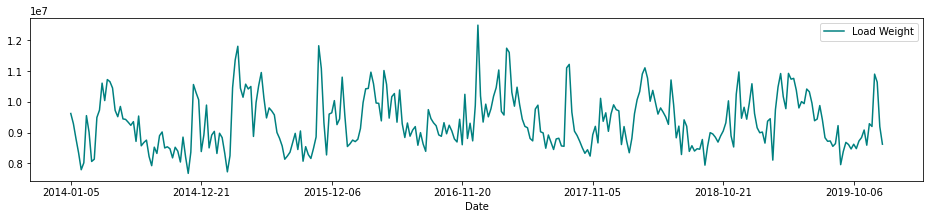

In [132]:
df_model.plot(y="Load Weight", color = "teal", figsize=(16,3))

In [133]:
!pip install statsmodels -q
from statsmodels.tsa.arima.model import ARIMA

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [134]:
import itertools
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
seasonal_pdq

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (3, 0, 0, 12),
 (3, 0, 1, 12),
 (3, 1, 0, 12),
 (3, 1, 1, 12)]

In [135]:
train_data = df_model['2014-01-05':'2018-12-30']["Load Weight"]
test_data = df_model['2019-01-06':'2019-12-29']["Load Weight"]

In [136]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
import statsmodels.api as sm

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [137]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 6299.152765646029 for model SARIMAX(3, 1, 1)x(3, 1, 1, 12)


In [138]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

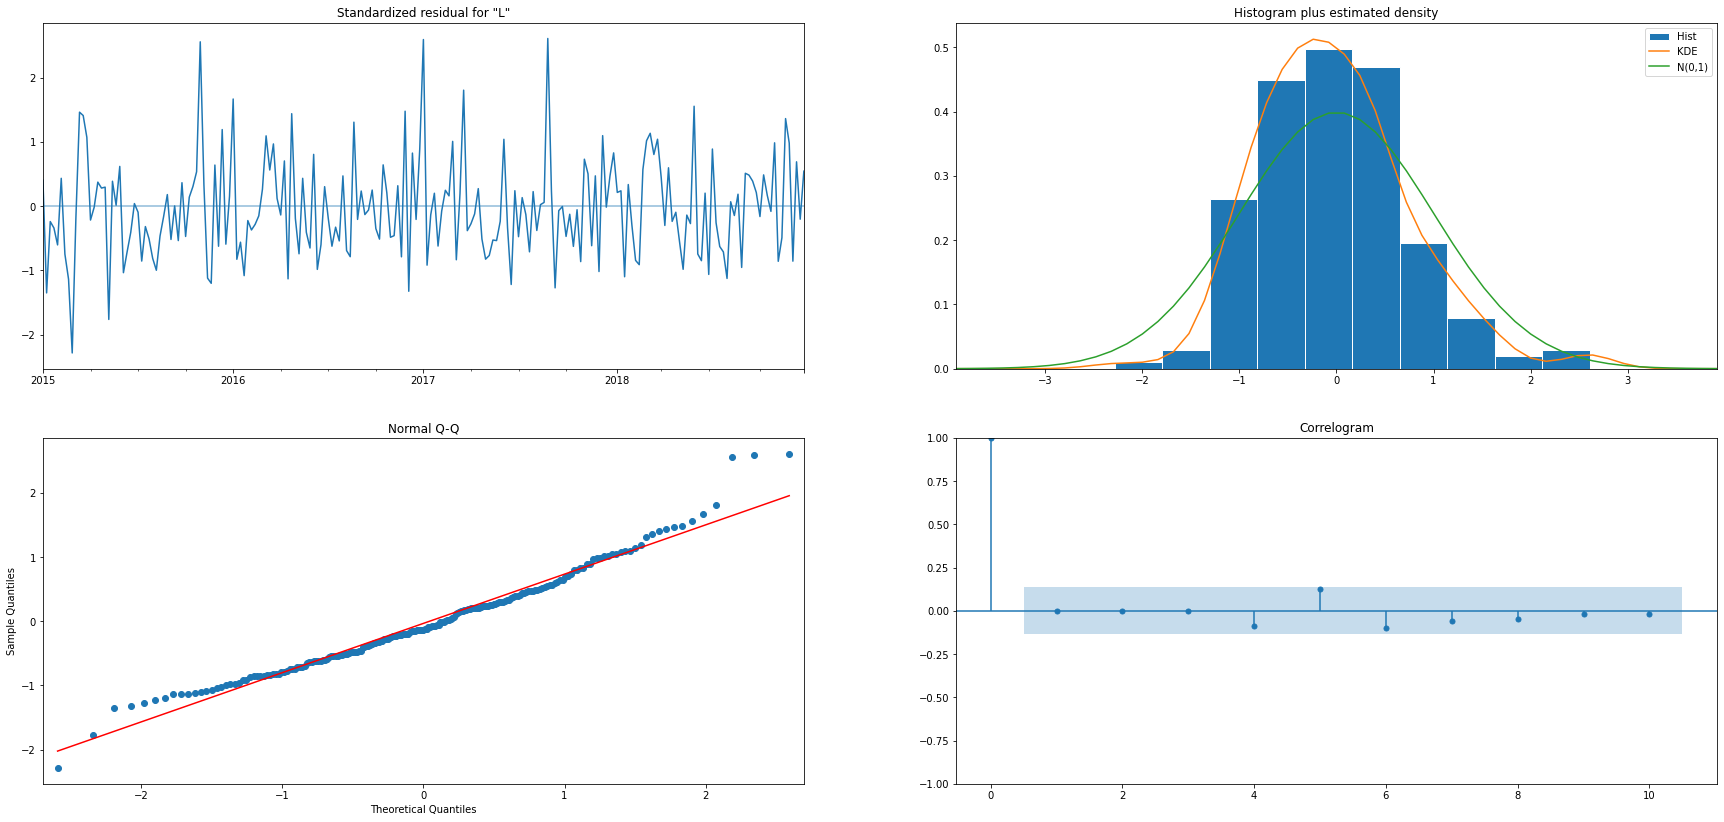

In [139]:
results.plot_diagnostics(figsize=(30, 14))
plt.show()

In [141]:
pred0 = results.get_prediction(start='2018-12-23', dynamic=False)
pred0_ci = pred0.conf_int()

In [142]:
pred0_ci

,lower Load Weight,upper Load Weight
2018-12-23,7683358.742280,11592609.616786
2018-12-30,7464698.971645,11373949.846151


In [143]:
pred1 = results.get_prediction(start='2018-12-23', dynamic=True)
pred1_ci = pred0.conf_int()

In [144]:
pred1_ci

,lower Load Weight,upper Load Weight
2018-12-23,7683358.742280,11592609.616786
2018-12-30,7464698.971645,11373949.846151


In [145]:
pred2 = results.get_forecast('2019-12-29')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2019-01-06':'2019-12-29'])

2019-01-06    9510270.219185
2019-01-13    9437664.427662
2019-01-20    9704388.007013
2019-01-27    9845736.018536
2019-02-03    9699878.797258
2019-02-10   10006448.438760
2019-02-17   10211606.609463
2019-02-24   10232370.128998
2019-03-03   10007554.883825
2019-03-10    9641582.427940
2019-03-17    9797838.212046
2019-03-24    9795877.354202
2019-03-31    9405253.013085
2019-04-07    9499306.670187
2019-04-14    9627451.852830
2019-04-21    9748539.695752
2019-04-28    9542656.669930
2019-05-05   10011356.092853
2019-05-12    9953367.093898
2019-05-19    9932210.902094
2019-05-26    9848134.845731
2019-06-02    9490790.182868
2019-06-09    9736821.989395
2019-06-16    9707429.397015
2019-06-23    9341490.275358
2019-06-30    9451900.436178
2019-07-07    9560656.159387
2019-07-14    9782288.634185
2019-07-21    9446307.742278
2019-07-28    9725639.667570
2019-08-04    9867056.705266
2019-08-11   10097221.272871
2019-08-18    9842532.664719
2019-08-25    9670722.251069
2019-09-01    

In [147]:
prediction = pred2.predicted_mean['2019-01-06':'2019-12-28'].values
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((test_data - prediction) / test_data)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 2019 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 2019 is 9.19%


## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

- https://routereadytrucks.com/blogs/know-4-major-types-garbage-trucks/

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.


### Open Street Maps

OSM dataset contains waste management locations listed in OpenStreetMap (OSM). Specifically, it includes OSM features having the tags "amenity:recycling", "amenity:waste_transfer_station", "amenity:sanitary_dump_station", "amenity:waste_disposal", or "industrial:scrap_yard". It includes a poi_type, a poi_name, and all other OSM tags as associated with the point (see https://taginfo.openstreetmap.org/tags).

In [ ]:
key = "amenity"
url = "https://taginfo.openstreetmap.org/api/4/key/values"

response = requests.get(url, params={
                        'key' : key,
                        'page' : 0, 'rp':100,
                        'sortname':'count', 'sortorder':'desc'
})

data_osm = response.json()['data']
df = pd.DataFrame(data_osm).set_index('value')
df[['count','description']].head()

In [ ]:
%%bash
wget    https://download.bbbike.org/osm/extract/planet_-98.323,29.94_-97.185,30.569.osm.pbf \
    --quiet -O data/Austin.osm.pbf

In [ ]:
!ogrinfo data/Austin.osm.pbf

In [ ]:
%%bash
ogr2ogr \
  -f "GPKG" data/austin_points.gpkg \
      data/Austin.osm.pbf \

In [ ]:
gdf_points = gpd.read_file("data/austin_points.gpkg", driver='GPKG')
gdf_points.head(2)

In [ ]:
gdf_points.loc[0,"other_tags"]
gdf_points["geometry"]

In [ ]:
%%bash
ogr2ogr \
  -f "GPKG" data/austin_poly.gpkg \
      data/Austin.osm.pbf \
    -nlt POLYGONS \
    -nln polygons

In [ ]:
#Read data
layer_file = "data/austin_poly.gpkg"
collection = list(fiona.open(layer_file,'r'))
df1 = pd.DataFrame(collection)

#Check Geometry
def isvalid(geom):
    try:
        shape(geom)
        return 1
    except:
        return 0
df1['isvalid'] = df1['geometry'].apply(lambda x: isvalid(x))
df1 = df1[df1['isvalid'] == 1]
collection = json.loads(df1.to_json(orient='records'))

#Convert to geodataframe
gdf = gpd.GeoDataFrame.from_features(collection)

In [ ]:
gdf.head()

In [ ]:
gdf.to_csv("data/austin_poly.csv")
gdf.columns.nunique()
gdf.columns.unique

OSM dataset contains waste management locations listed in OpenStreetMap (OSM). Specifically, it includes OSM features having the tags "amenity:recycling", "amenity:waste_transfer_station", "amenity:sanitary_dump_station", "amenity:waste_disposal", or "industrial:scrap_yard"

In [ ]:
gdf_poly = pd.read_csv("data/austin_poly.csv")

In [ ]:
gdf_poly.columns.unique

In [ ]:
# reducing features
poi_austin = gdf_poly[['geometry', 'osm_id','name','amenity','building', 'natural', 'shop', 'leisure',  'office', 'sport', 'tourism']]

In [ ]:
# removing all nan vals
def remove_rows(df):
    df_mod = df
    df_mod = df.dropna(how='all', subset=['amenity', 'natural', 'shop', 'leisure', 'tourism'])
#     df_mod = df_mod[~df_mod.is_empty] # check if neccessary
    return df_mod

In [ ]:
poi_austin_clean = remove_rows(poi_austin)
poi_austin_clean

In [ ]:
poi_austin_clean['amenity'].unique()

In [ ]:
poi_austin_clean['natural'].unique()

In [ ]:
poi_austin_clean['shop'].unique()

In [ ]:
poi_austin_clean['leisure'].unique()

In [ ]:
poi_austin_clean['tourism'].unique()

In [ ]:
# leisure = ['garden', 'park']

# the polygons of the actual green spaces are also in the data set
parks = poi_austin_clean[(poi_austin_clean['leisure'] == 'park') | (poi_austin_clean['leisure'] == 'garden')]
parks = parks.set_crs(epsg=4326)
poi_austin_clean = poi_austin_clean.drop(parks.index) # remove the used shapes
parks['geom'] = parks.geometry # not to loose it while joining
matches = gpd.sjoin(green_areas_dic, 
                    parks[['geometry', 'geom']], 
                    op='within',
                   ).drop(columns=['index_right', 
                                   'geometry']).rename(columns={'geom':'geometry'})

green_areas_shape = matches

### Weather Data

In [ ]:
#!pip install meteostat
#!pip install pyairnow

**Data Structure**

Each hour is represented by a Pandas DataFrame row which provides the weather data recorded at that time. 

These are the different columns:

Column	Description	Type

- station	The Meteostat ID of the weather station (only if query refers to multiple stations)	String
- time	The datetime of the observation	Datetime64
- temp	The air temperature in °C	Float64
- dwpt	The dew point in °C	Float64
- rhum	The relative humidity in percent (%)	Float64
- prcp	The one hour precipitation total in mm	Float64
- snow	The snow depth in mm	Float64
- wdir	The average wind direction in degrees (°)	Float64
- wspd	The average wind speed in km/h	Float64
- wpgt	The peak wind gust in km/h	Float64
- pres	The average sea-level air pressure in hPa	Float64
- tsun	The one hour sunshine total in minutes (m)	Float64
- coco	The weather condition code	Float64


In [ ]:

# Get weather stations ordered by distance to Austin, TX 
#(30.4895484046493" N, 97.7249632541566" W) || Latitude of Austin (TX) 30.267153. Longitude of Austin (TX) -97.7430608.
Aus_lat = 30.267153
Aus_long = -97.7430608

# Set time period
start = datetime(2005, 1, 1)
end = datetime(2021, 12, 31, 23, 59)

#Fetch closest station (limit = 1)
stations = Stations()
stations = stations.nearby(Aus_lat, Aus_long)
stations = stations.inventory('daily', (start, end))
location = stations.fetch(1)

# Create Point for Austin, TX
#location = Point(Aus_lat, Aus_long, 70)

# Get daily data for 2005 to 2021
data = Daily(location, start, end)
#data_h = Hourly(location, start, end) 

# Plot line chart including average, minimum and maximum temperature
#data.plot(y=['tavg', 'tmin', 'tmax'])
#plt.show()

The normalize method makes sure that gaps in the time series are filled. necessary before interpolation

Aggregate Functions
Meteostat uses the following aggregate functions:

- temp => mean
- dwpt => mean
- rhum => mean
- tavg => mean
- tmin => min
- tmax => max
- prcp => sum
- snow => max
- wdir => meteostat.utilities.aggregations.degree_mean
- wspd => mean
- wpgt => max
- pres => mean
- tsun => sum
- coco => max

In [ ]:
data = data.normalize()
data = data.interpolate()
data_w = data.aggregate('1W') # Weekly aggregation according to above function
data_w = data_w.fetch()

data = data.aggregate('1D')
data = data.fetch()

data.head()

In [ ]:
print(data.shape)
print(data_w.shape)

In [ ]:
data.to_csv("WeatherData_weekly.csv")
data_w.to_csv("WeatherData_weekly.csv")

In [ ]:
data_w.describe()

In [ ]:
data.describe()

### Pollution Data

In [ ]:
'''import requests 
from six.moves import urllib

APIkey = 'C0944E2A-D5D0-4231-ABAB-5F7530450F2A'

#&zipCode=78708&date=2022-03-18T00-0000&distance=50&API_KEY=C0944E2A-D5D0-4231-ABAB-5F7530450F2A
url = 'https://www.airnowapi.org/aq/observation/latLong/historical/?format=text/csv&latitude={}&longitude={}&date={}T00-0000&distance=50&API_KEY={}'.format(Aus_lat,Aus_long,start,APIkey)

Pdata = requests.get(url)
airdata = Pdata.json()
print(airdata)
'''


In [ ]:
import pandas as pd 

PMdata = pd.read_csv('./austin-texas-air-quality.csv')
PMdata.head()

In [ ]:
PMdata.tail()

In [ ]:
PMdata['date'] = pd.to_datetime(PMdata["date"].astype(str), format='%Y-%m-%d')
PMdata.rename(columns = {'date':'time'}, inplace = True)
PMdata.set_index('time')
print(PMdata.shape)
PMdata.head()

In [ ]:
Weather_merged_daily = pd.merge(data, PMdata, on=['time'])
Weather_merged_daily.to_csv('Weather_merged_daily.csv')
print(Weather_merged_daily.shape)
Weather_merged_daily.head()

In [ ]:
PMdata.describe()

In [ ]:
import datetime as dt

PMdata_w = PMdata.copy()

PMdata_w['WeekDate'] = PMdata_w.apply(lambda row: row['time'] - dt.timedelta(days=row['time'].weekday()+1),axis=1)
PMdata_w[' pm25']= pd.to_numeric(PMdata_w[' pm25'],errors = 'coerce',downcast="integer")
PMdata_w[' o3']= pd.to_numeric(PMdata_w[' o3'],errors = 'coerce',downcast="integer")
PMdata_w[' no2']= pd.to_numeric(PMdata_w[' no2'],errors = 'coerce',downcast="integer")
PMdata_w[' so2']= pd.to_numeric(PMdata_w[' so2'],errors = 'coerce',downcast="integer")
#print(PMdata_w.dtypes)
perweek = PMdata_w[' pm25'].groupby(PMdata_w['WeekDate']).mean()
perweek

In [ ]:
#perweek.rename(columns = {'WeekDate':'time'}, inplace = True)
perweek_df = pd.DataFrame(perweek)
#perweek_df = perweek_df.rename(columns = {'WeekDate':'time'})
perweek_df.index.names = ['time']
perweek_df

In [ ]:
Weather_merged_weekly = pd.merge(data_w, perweek_df, on=['time'])
print(Weather_merged_weekly.shape)
Weather_merged_weekly.head()

In [ ]:
Weather_merged_weekly.to_csv('Weather_merged_weekly.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1a1cabe9-69f7-4a67-be18-e232e1feb2b6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>